In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import warnings

warnings.filterwarnings("ignore")

Leemos los datos del dataset

In [2]:
# Lee el archivo CSV
df = pd.read_csv('student.csv')

# Calculamos la media de las columnas G1 y G2
df['Media_G1_G2'] = df[['G1', 'G2']].mean(axis=1)

# Definimos una función para asignar las categorías
def asignar_categoria(media):
    if media < 10:
        return "suspenso"
    else:
        return "aprobado"

# Aplicamos la función a la nueva columna para crear la columna de categorías
df['Calificacion'] = df['Media_G1_G2'].apply(asignar_categoria)
    
# Con esta función seleccionamos los atributos categóricos y los transformamos a codificación one-hot
categorical_columns = df.select_dtypes(include=['object']).columns
for i in categorical_columns:
    if len(df[i].unique()) == 2:
        # Si solo hay dos categorías, usar LabelEncoder
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
    else:
        df_dummies = pd.get_dummies(df[i], prefix=i)
        df = pd.concat([df.drop(i, axis=1), df_dummies],axis=1)
df['Media_G1_G2'] = df['Media_G1_G2'].astype(int)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   school             649 non-null    int64
 1   sex                649 non-null    int64
 2   age                649 non-null    int64
 3   address            649 non-null    int64
 4   famsize            649 non-null    int64
 5   Pstatus            649 non-null    int64
 6   Medu               649 non-null    int64
 7   Fedu               649 non-null    int64
 8   traveltime         649 non-null    int64
 9   studytime          649 non-null    int64
 10  schoolsup          649 non-null    int64
 11  famsup             649 non-null    int64
 12  paid               649 non-null    int64
 13  activities         649 non-null    int64
 14  nursery            649 non-null    int64
 15  higher             649 non-null    int64
 16  internet           649 non-null    int64
 17  romantic        

Particionamos los datos en train y test, luego dividimos de nuevo para los dos conjuntos de notas que tenemos

In [3]:
# Hacemos un particionamiento estándar, 70% para train y 30% para test
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

# Sacamos los atributos target
y_train_G1 = train_data['G1']
y_train_G2 = train_data['G2']
y_train_media = train_data['Media_G1_G2']


# Definimos X con el resto de atributos que no son los targets
X_train = train_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)

# Sacamos los atributos target
y_test_G1 = test_data['G1']
y_test_G2 = test_data['G2']
y_test_media = test_data['Media_G1_G2']

# Definimos X con el resto de atributos que no son los targets
X_test = test_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)

Estandarizamos todos los datos que vamos a emplear

In [4]:
# Creamos el estandarizador
scaler = StandardScaler()

# Ajustamos el estandarizador con los datos de entrenamiento y luego transformamos los datos de entrenamiento
X_train = scaler.fit_transform(X_train)

# Transformamos los datos de prueba con el estandarizador ajustado
X_test = scaler.transform(X_test)

Creamos y entrenamos el modelo. Calculamos los atributos del modelo, como su salida, error y accuracy

In [5]:
# Aplicamos el modelo de regresión lineal
modelo_lineal_G1 = LinearRegression()
modelo_lineal_G2 = LinearRegression()
modelo_lineal_media = LinearRegression()

# Entrenamos el modelo
modelo_lineal_G1.fit(X_train, y_train_G1)
modelo_lineal_G2.fit(X_train, y_train_G2)
modelo_lineal_media.fit(X_train, y_train_media)

# Calculamos la salida del modelo
y_pred_G1 = modelo_lineal_G1.predict(X_test)
y_pred_G2 = modelo_lineal_G2.predict(X_test)
y_pred_media = modelo_lineal_media.predict(X_test)

# Medimos el error cuadrático medio del modelo
mse_G1 = mean_squared_error(y_test_G1, y_pred_G1)
mse_G2 = mean_squared_error(y_test_G2, y_pred_G2)
mse_media = mean_squared_error(y_test_media, y_pred_media)

# Redondeamos las predicciones al entero más cercano
y_pred_G1_rounded = np.round(y_pred_G1)
y_pred_G2_rounded = np.round(y_pred_G2)
y_pred_media_rounded = np.round(y_pred_media)

# Calculamos la precisión del modelo
accuracy_G1 = accuracy_score(y_test_G1, y_pred_G1_rounded)
accuracy_G2 = accuracy_score(y_test_G2, y_pred_G2_rounded)
accuracy_media = accuracy_score(y_test_media, y_pred_media_rounded)

print("Precision para G1 = ", round(accuracy_G1*100,2), "%")
print("Precision para G2 = ", round(accuracy_G2*100,2), "%")
print("Precision para Media = ", round(accuracy_media*100,2), "%")

# Generamos las predicciones del modelo para los datos de entrenamiento
y_train_pred_G1 = modelo_lineal_G1.predict(X_train)
y_train_pred_G2 = modelo_lineal_G2.predict(X_train)
y_train_pred_media = modelo_lineal_media.predict(X_train)

Precision para G1 =  14.36 %
Precision para G2 =  14.87 %
Precision para Media =  21.03 %


Graficamos los datos que hemos calculado

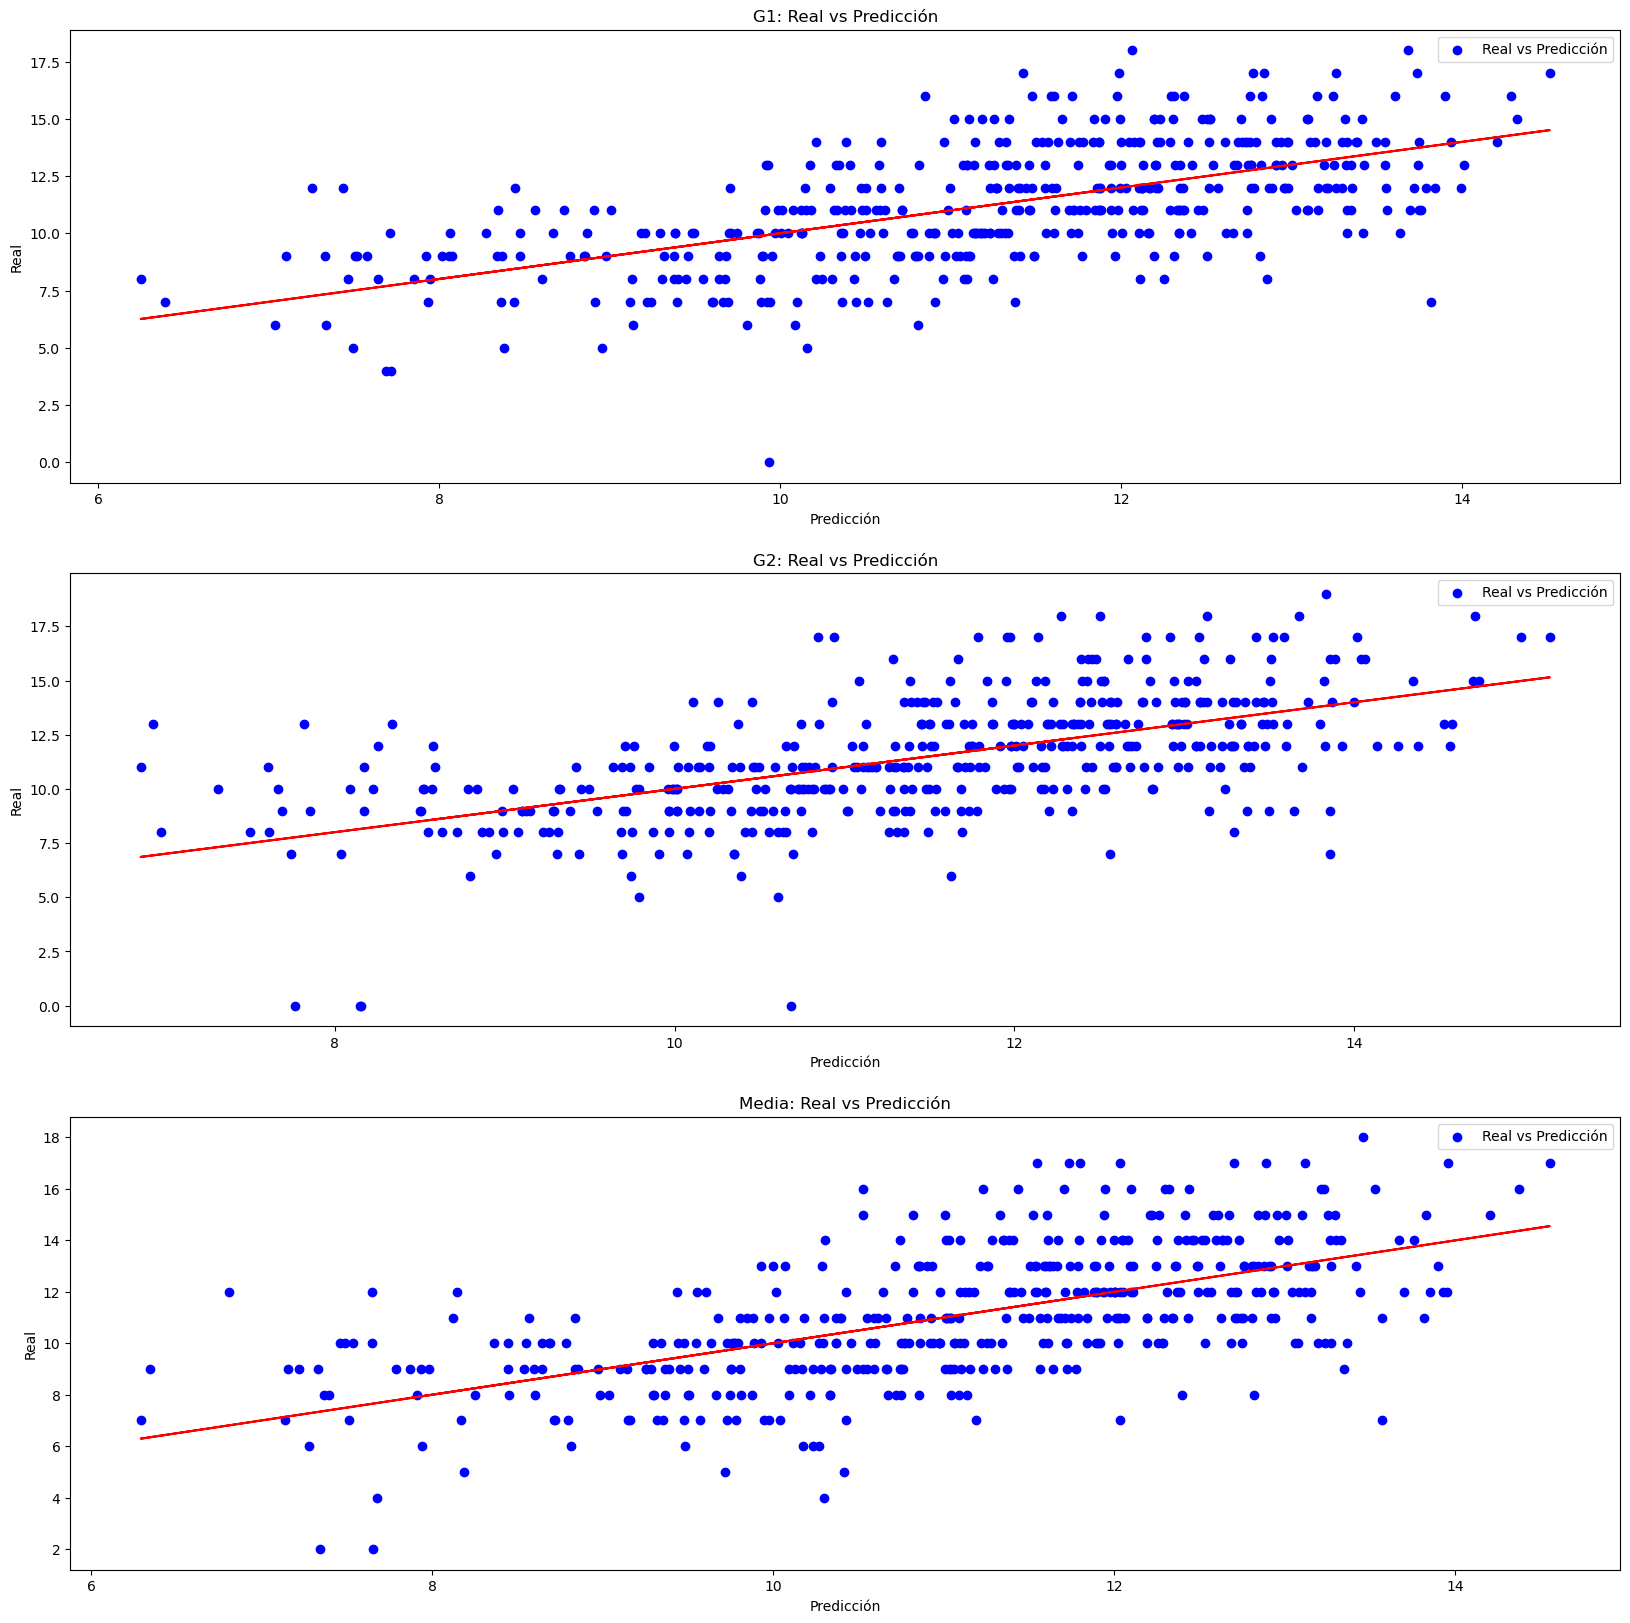

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Creamos una figura y un conjunto de subtramas
fig, ax = plt.subplots(3, 1, figsize=(20, 20))

# Graficamos los datos reales y las predicciones del modelo para G1
ax[0].scatter(y_train_pred_G1, y_train_G1, color='blue', label='Real vs Predicción')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_train_pred_G1, y_train_G1, 1)
ax[0].plot(y_train_pred_G1, m*y_train_pred_G1 + b, color='red')

ax[0].set_title('G1: Real vs Predicción')
ax[0].set_xlabel('Predicción')
ax[0].set_ylabel('Real')
ax[0].legend()

# Graficamos los datos reales y las predicciones del modelo para G2
ax[1].scatter(y_train_pred_G2, y_train_G2, color='blue', label='Real vs Predicción')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_train_pred_G2, y_train_G2, 1)
ax[1].plot(y_train_pred_G2, m*y_train_pred_G2 + b, color='red')

ax[1].set_title('G2: Real vs Predicción')
ax[1].set_xlabel('Predicción')
ax[1].set_ylabel('Real')
ax[1].legend()

# Graficamos los datos reales y las predicciones del modelo para Media
ax[2].scatter(y_train_pred_media, y_train_media, color='blue', label='Real vs Predicción')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_train_pred_media, y_train_media, 1)
ax[2].plot(y_train_pred_media, m*y_train_pred_media + b, color='red')

ax[2].set_title('Media: Real vs Predicción')
ax[2].set_xlabel('Predicción')
ax[2].set_ylabel('Real')
ax[2].legend()

# Mostramos la figura
plt.show()

Grado del polinomio: 3
Precision para G1 =  16.92 %
Precision para G2 =  15.9 %
Precision para Media =  16.41 %




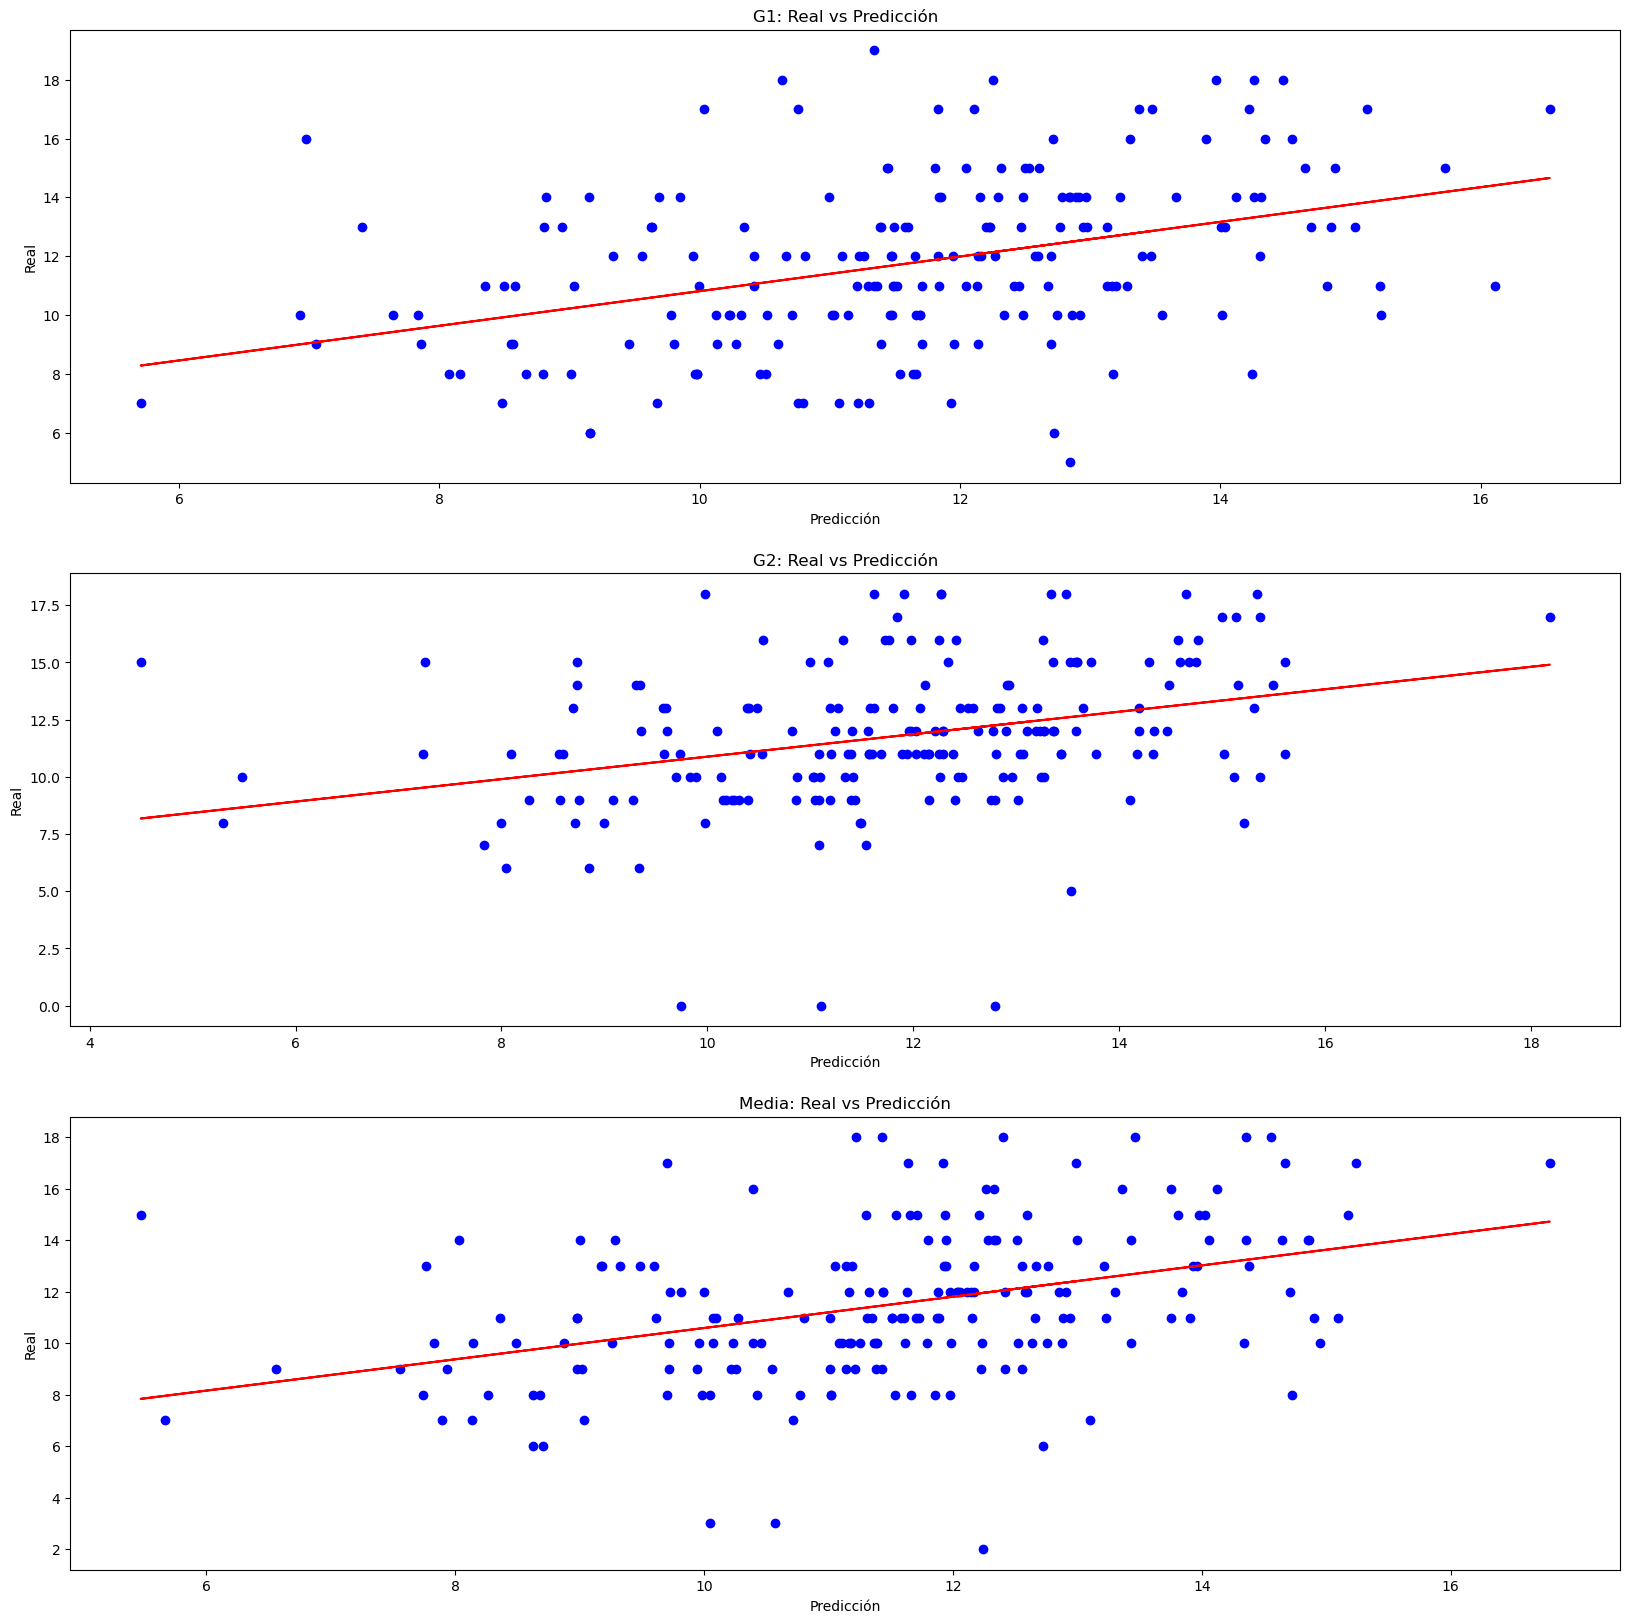

In [7]:
# Creamos una instancia de StandardScaler para estandarizar nuestros datos
scaler_G1 = StandardScaler()
scaler_G2 = StandardScaler()
scaler_media = StandardScaler()

# Ajustamos y transformamos los datos de entrenamiento y luego transformamos los datos de prueba
X_train = scaler_G1.fit_transform(X_train)
X_test = scaler_G1.transform(X_test)

# Creamos una instancia de LinearRegression
model_G1 = LinearRegression()
model_G2 = LinearRegression()
model_media = LinearRegression()

degree = 3

# Creamos una instancia de PolynomialFeatures para transformar nuestros datos a un espacio polinomial
poly = PolynomialFeatures(degree=degree)

# Transformamos nuestros datos de entrenamiento y de prueba
X_train_poly_G1 = poly.fit_transform(X_train)
X_test_poly_G1 = poly.transform(X_test)

X_train_poly_G2 = poly.fit_transform(X_train)
X_test_poly_G2 = poly.transform(X_test)

X_train_poly_media = poly.fit_transform(X_train)
X_test_poly_media = poly.transform(X_test)

# Entrenamos el modelo
model_G1.fit(X_train_poly_G1, y_train_G1)
model_G2.fit(X_train_poly_G2, y_train_G2)
model_media.fit(X_train_poly_media, y_train_media)

# Hacemos predicciones
y_pred_G1 = model_G1.predict(X_test_poly_G1)
y_pred_G2 = model_G2.predict(X_test_poly_G2)
y_pred_media = model_media.predict(X_test_poly_media)

# Calculamos la precisión del modelo
precision_G1 = accuracy_score(y_test_G1, np.round(y_pred_G1))
precision_G2 = accuracy_score(y_test_G2, np.round(y_pred_G2))
precision_media = accuracy_score(y_test_media, np.round(y_pred_media))

print(f"Grado del polinomio: {degree}")
print("Precision para G1 = ", round(precision_G1*100,2), "%")
print("Precision para G2 = ", round(precision_G2*100,2), "%")
print("Precision para Media = ", round(precision_media*100,2), "%")
print("\n")

# Creamos una figura y un conjunto de subtramas
fig, ax = plt.subplots(3, 1, figsize=(20, 20))

# Graficamos los datos reales y las predicciones del modelo para G1
ax[0].scatter(y_pred_G1, y_test_G1, color='blue')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_pred_G1, y_test_G1, 1)
ax[0].plot(y_pred_G1, m*y_pred_G1 + b, color='red')

ax[0].set_title('G1: Real vs Predicción')
ax[0].set_xlabel('Predicción')
ax[0].set_ylabel('Real')

# Graficamos los datos reales y las predicciones del modelo para G2
ax[1].scatter(y_pred_G2, y_test_G2, color='blue')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_pred_G2, y_test_G2, 1)
ax[1].plot(y_pred_G2, m*y_pred_G2 + b, color='red')

ax[1].set_title('G2: Real vs Predicción')
ax[1].set_xlabel('Predicción')
ax[1].set_ylabel('Real')

# Graficamos los datos reales y las predicciones del modelo para G2
ax[2].scatter(y_pred_media, y_test_media, color='blue')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_pred_media, y_test_media, 1)
ax[2].plot(y_pred_media, m*y_pred_media + b, color='red')

ax[2].set_title('Media: Real vs Predicción')
ax[2].set_xlabel('Predicción')
ax[2].set_ylabel('Real')

# Mostramos la figura
plt.show()

### Regresion Logística

In [8]:
y_train_calificacion = train_data['Calificacion']
y_test_calificacion = test_data['Calificacion']

# Aplicamos el modelo de regresion logistica
#modelo_logistico_calificacion = LogisticRegression(multi_class='multinomial', solver='lbfgs')
modelo_logistico_calificacion = LogisticRegression(multi_class='ovr', solver='liblinear')

# Entrenamos el modelo
modelo_logistico_calificacion.fit(X_train, y_train_calificacion)

# Calculamos la salida del modelo
y_pred_calificacion = modelo_logistico_calificacion.predict(X_test)

# Medimos la precision del modelo
precision_calificacion = accuracy_score(y_test_calificacion, y_pred_calificacion)
                                     
print("Precision para Categoria = ", round(precision_calificacion*100,2), "%")

Precision para Categoria =  83.08 %


### Ensembles Adaboost

In [9]:
numero_clasificadores_base = 1
mejor_acc_calificacion = 0
lista_precision_calificacion = []


for i in range(1, 100):
    #Defininos el clasificadores base
    clasificador_base = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    
    #Definimos el modelo y entrenamos
    adaboost_semana = AdaBoostClassifier(base_estimator=clasificador_base, n_estimators=numero_clasificadores_base, random_state=12)
    adaboost_semana.fit(X_train, y_train_calificacion)
    
    #Calculamos la precision
    accuracy_calificacion = round(100*adaboost_semana.score(X_test, y_test_calificacion), 2)
    
    #Añadimos las precisiones a su correspondiente lista para dibujarlas en las graficas
    lista_precision_calificacion.append(accuracy_calificacion)
    
    #Comprobamos cual es el mejor numero de clasificadores para obtener la mayor precision
    if (accuracy_calificacion >= mejor_acc_calificacion):
        mejor_acc_calificacion = accuracy_calificacion
        mejor_num_clasificadores_calificacion = numero_clasificadores_base
        
    numero_clasificadores_base += 1
    
print("El mejor numero de clasificadores es: " + str(mejor_num_clasificadores_calificacion) + ", con una precision del: " + str(mejor_acc_calificacion), "%")

El mejor numero de clasificadores es: 24, con una precision del: 82.05 %


### Red Neuronal

In [15]:
from sklearn.neural_network import MLPClassifier

max_acc = 0
max_hidden_layer = 0
max_iteration = 0

accuracies = np.zeros(15)


for i in range(1, 3):
    for j in range(1, 100):
        clasificador = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(i,), max_iter=j)
        clasificador.fit(X_train, y_train_calificacion)

        y_pred = clasificador.predict(X_test)

        accuracy = accuracy_score(y_test_calificacion, y_pred)
        
        if (accuracy >= max_acc):
            max_hidden_layer = i
            max_acc = accuracy
            max_iteration = j
            
    #accuracies[i] = accuracy
    
print("El mejor numero de capas es: " + str(max_hidden_layer) + ", con una precision del: " + str(max_acc), "%")
print("Itersciones: " + str(max_iteration))


"""
fig, ax = plt.subplots()
ax.plot(accuracies)
ax.set_xlabel("Iteraciones")
ax.set_ylabel("Accuracy")
"""

El mejor numero de capas es: 8, con una precision del: 0.8358974358974359 %
Itersciones: 23


'\nfig, ax = plt.subplots()\nax.plot(accuracies)\nax.set_xlabel("Iteraciones")\nax.set_ylabel("Accuracy")\n'

In [ ]:
# Lee el archivo CSV
df = pd.read_csv('student.csv')

# Selecciona solo las columnas 'G1' y 'G2'
df = df[['G1', 'G2']]

# Divide los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Estandariza los datos de entrenamiento
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Estandariza los datos de prueba
test_data_scaled = scaler.transform(test_data)

# Inicializa la lista para guardar los índices de Davies-Bouldin
db_scores = []

# Prueba diferentes valores de k
for k in range(2, 10):
    # Crea el modelo de K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Ajusta el modelo a los datos de entrenamiento
    kmeans.fit(train_data_scaled)

    # Obtiene las etiquetas de los clusters para los datos de entrenamiento
    train_labels = kmeans.labels_

    # Predice las etiquetas de los clusters para los datos de prueba
    test_labels = kmeans.predict(test_data_scaled)

    # Calcula el índice de Davies-Bouldin para los datos de entrenamiento
    db_score = davies_bouldin_score(train_data_scaled, train_labels)
    
    # Guarda el índice de Davies-Bouldin en la lista
    db_scores.append(db_score)

# Encuentra el valor de k que da el índice de Davies-Bouldin más bajo
best_k = db_scores.index(min(db_scores)) + 2

print("El mejor valor de k es: ", best_k)